In [1]:
# Training-focused imports for pre-processed data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_theme(style="whitegrid")


In [2]:
import os
os.listdir("/kaggle/input")

os.listdir("/kaggle/input/urbanflow")

path = "/kaggle/input/urbanflow/merged_dataset_20250720_170853.csv"

df = pd.read_csv(path)

df.head()


,start_station_id,date,hour,demand_count,datetime_hour,ride_distance_km,ride_duration,is_weekend,is_peak_hour,temperature_2m,...,weather_severity,is_good_biking_weather,has_precipitation,is_comfortable_temp,is_windy,season,traffic_mean,traffic_max,traffic_sum,traffic_count
0,2733.03,2023-01-06,8,1,2023-01-06 08:00:00,1.793862,9.834400,0.0,1.0,5.8225,...,7.382609,0.0,1.0,0.0,0.0,Winter,256.50,256.50,256.50,1.0
1,2733.03,2023-01-06,15,1,2023-01-06 15:00:00,1.178464,7.245450,0.0,0.0,6.3725,...,4.409914,0.0,1.0,0.0,0.0,Winter,222.25,222.25,222.25,1.0
2,2733.03,2023-01-06,18,2,2023-01-06 18:00:00,1.686254,61.685567,0.0,1.0,7.1725,...,8.362780,0.0,1.0,0.0,0.0,Winter,169.75,169.75,169.75,1.0
3,2733.03,2023-01-06,21,1,2023-01-06 21:00:00,5.233720,15.836367,0.0,0.0,7.8725,...,4.917823,0.0,0.0,0.0,0.0,Winter,137.50,137.50,137.50,1.0
4,2733.03,2023-01-08,8,1,2023-01-08 08:00:00,1.793862,8.985350,1.0,1.0,0.0225,...,5.358493,0.0,0.0,0.0,0.0,Winter,107.25,107.25,107.25,1.0


In [3]:
df.shape

(6298240, 22)

In [4]:
# Data Preparation - 6-Month Filtering for Speed Optimization
# Data is already cleaned and feature-engineered, just filter for faster training

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def filter_to_last_6_months(df):
    """
    Filter dataset to last 6 months for faster training
    """
    print("📅 Filtering dataset to last 6 months for speed optimization...")
    
    # Find date columns
    date_columns = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['date', 'time', 'timestamp', 'datetime']):
            date_columns.append(col)
    
    if not date_columns:
        # Try to identify date-like columns by content
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_values = df[col].dropna().head(5).astype(str)
                if any('2024' in str(val) or '2025' in str(val) or '/' in str(val) or '-' in str(val) for val in sample_values):
                    date_columns.append(col)
    
    print(f"   📋 Found potential date columns: {date_columns}")
    
    if not date_columns:
        print("   ⚠️ No date columns found - keeping full dataset")
        return df, len(df)
    
    original_size = len(df)
    
    # Try each date column to find the best one
    for date_col in date_columns:
        try:
            print(f"   🔍 Trying date column: {date_col}")
            
            # Convert to datetime
            df_temp = df.copy()
            df_temp[date_col] = pd.to_datetime(df_temp[date_col], errors='coerce')
            
            # Remove rows where date conversion failed
            valid_dates = df_temp[date_col].notna()
            if valid_dates.sum() == 0:
                print(f"   ❌ No valid dates in {date_col}")
                continue
            
            df_temp = df_temp[valid_dates]
            
            # Get the latest date and calculate 6 months back
            latest_date = df_temp[date_col].max()
            six_months_ago = latest_date - timedelta(days=180)  # Approximately 6 months
            
            print(f"   📊 Date range: {df_temp[date_col].min()} to {latest_date}")
            print(f"   ✂️ Filtering from: {six_months_ago}")
            
            # Filter to last 6 months
            filtered_df = df_temp[df_temp[date_col] >= six_months_ago].copy()
            
            if len(filtered_df) > 0:
                filtered_size = len(filtered_df)
                reduction_pct = (1 - filtered_size/original_size) * 100
                
                print(f"   ✅ Successfully filtered using {date_col}")
                print(f"   📉 Dataset reduced: {original_size:,} → {filtered_size:,} ({reduction_pct:.1f}% reduction)")
                
                return filtered_df, original_size
            
        except Exception as e:
            print(f"   ❌ Failed to filter using {date_col}: {str(e)}")
            continue
    
    print("   ⚠️ Could not filter by date - keeping full dataset")
    return df, original_size

def prepare_training_data(df, target_col=None, test_size=0.2, filter_months=True):
    """
    Prepare clean data for model training (assumes data is already preprocessed)
    """
    print("🔄 Preparing clean data for model training...")
    
    original_size = len(df)
    
    # Apply 6-month filtering for faster training
    if filter_months:
        df, original_size = filter_to_last_6_months(df)
        print(f"📊 Working with {len(df):,} samples after 6-month filtering")
    else:
        print(f"📊 Working with full dataset: {len(df):,} samples")
    
    # Auto-detect target column if not specified
    if target_col is None:
        target_candidates = [col for col in df.columns if any(keyword in col.lower() for keyword in ['demand', 'count', 'target', 'y', 'label'])]
        if target_candidates:
            target_col = target_candidates[0]
            print(f"🎯 Auto-detected target column: {target_col}")
        else:
            print("❌ No target column specified and none auto-detected")
            print(f"Available columns: {list(df.columns)}")
            return None
    
    # Validate target column exists
    if target_col not in df.columns:
        print(f"❌ Target column '{target_col}' not found")
        print(f"Available columns: {list(df.columns)}")
        return None
    
    # Separate features and target
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Basic validation
    print(f"\n📊 Dataset Summary:")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Samples: {len(df):,}")
    print(f"   Target: {target_col}")
    print(f"   Target range: {y.min():.1f} - {y.max():.1f}")
    print(f"   Target mean: {y.mean():.1f} ± {y.std():.1f}")
    
    # Check for missing values
    missing_features = X.isnull().sum().sum()
    missing_target = y.isnull().sum()
    
    if missing_features > 0:
        print(f"⚠️ Found {missing_features} missing values in features")
    if missing_target > 0:
        print(f"⚠️ Found {missing_target} missing values in target")
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=True
    )
    
    print(f"\n✅ Training data prepared:")
    print(f"   🏋️ Training samples: {X_train.shape[0]:,}")
    print(f"   🧪 Test samples: {X_test.shape[0]:,}")
    
    if filter_months:
        print(f"   ⚡ Speed optimization: Using last 6 months ({len(df):,} vs {original_size:,} original)")
    
    # Show feature summary
    print(f"\n📋 Features ({len(X.columns)}):")
    for i, col in enumerate(X.columns):
        if i < 10:  # Show first 10
            dtype = str(X[col].dtype)
            nulls = X[col].isnull().sum()
            print(f"   {i+1:2d}. {col:<25} ({dtype}, {nulls} nulls)")
        elif i == 10:
            print(f"   ... and {len(X.columns)-10} more features")
            break
    
    return X_train, X_test, y_train, y_test, list(X.columns)

# Prepare the data with 6-month filtering for faster training
if 'df' in locals() and df is not None:
    print("🚀 Starting data preparation with 6-month filtering...")
    training_data = prepare_training_data(df, filter_months=True)
    
    if training_data is not None:
        X_train, X_test, y_train, y_test, feature_names = training_data
        print(f"\n🚀 Ready for FAST model training!")
        print(f"⚡ Dataset optimized for speed with 6-month filtering")
    else:
        print("❌ Data preparation failed - please check your dataset")
else:
    print("❌ No dataset loaded. Please run the data loading cell first.")

🚀 Starting data preparation with 6-month filtering...
🔄 Preparing clean data for model training...
📅 Filtering dataset to last 6 months for speed optimization...
   📋 Found potential date columns: ['date', 'datetime_hour']
   🔍 Trying date column: date
   📊 Date range: 2023-01-06 00:00:00 to 2023-12-10 00:00:00
   ✂️ Filtering from: 2023-06-13 00:00:00
   ✅ Successfully filtered using date
   📉 Dataset reduced: 6,298,240 → 3,436,954 (45.4% reduction)
📊 Working with 3,436,954 samples after 6-month filtering
🎯 Auto-detected target column: demand_count

📊 Dataset Summary:
   Features: 21
   Samples: 3,436,954
   Target: demand_count
   Target range: 1.0 - 117.0
   Target mean: 3.4 ± 4.0

✅ Training data prepared:
   🏋️ Training samples: 2,749,563
   🧪 Test samples: 687,391
   ⚡ Speed optimization: Using last 6 months (3,436,954 vs 6,298,240 original)

📋 Features (21):
    1. start_station_id          (object, 0 nulls)
    2. date                      (datetime64[ns], 0 nulls)
    3. hour 

In [5]:
# 📌 Remove non-numeric columns from training and test features
non_numeric_cols = ['start_station_id', 'date', 'datetime_hour', 'season']

X_train = X_train.drop(columns=non_numeric_cols, errors='ignore')
X_test = X_test.drop(columns=non_numeric_cols, errors='ignore')

print("✅ Dropped non-numeric columns:", non_numeric_cols)
print("📊 New shapes -> X_train:", X_train.shape, ", X_test:", X_test.shape)


✅ Dropped non-numeric columns: ['start_station_id', 'date', 'datetime_hour', 'season']
📊 New shapes -> X_train: (2749563, 17) , X_test: (687391, 17)


In [6]:
# Data Validation and Setup for Model Training
def validate_training_data(X_train, X_test, y_train, y_test):
    """
    Validate input data before training models
    """
    print("🔍 Validating input data...")
    
    # Check for non-numeric data
    if not all(X_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        print("❌ Non-numeric data detected in features!")
        print("   Non-numeric columns:", X_train.select_dtypes(exclude=[np.number]).columns.tolist())
        return False
    
    # Check for missing values
    if X_train.isnull().any().any():
        print("❌ Missing values detected in training features!")
        return False
    
    if X_test.isnull().any().any():
        print("❌ Missing values detected in test features!")
        return False
    
    # Check for infinite values
    if np.isinf(X_train.values).any():
        print("❌ Infinite values detected in training features!")
        return False
    
    print("✅ Data validation passed")
    return True

def detect_task_type(y_train):
    """
    Auto-detect whether this is a classification or regression task
    """
    unique_values = len(np.unique(y_train))
    if unique_values <= 20 and y_train.dtype in ['int64', 'int32', 'object', 'category']:
        task_type = 'classification'
        print("🔍 Auto-detected: Classification task")
    else:
        task_type = 'regression'
        print("🔍 Auto-detected: Regression task")
    
    return task_type

# Initialize variables for model results
if 'X_train' in locals() and X_train is not None:
    # Validate data
    data_valid = validate_training_data(X_train, X_test, y_train, y_test)
    
    if data_valid:
        # Detect task type
        task_type = detect_task_type(y_train)
        
        # Initialize results storage
        model_results_list = []
        trained_models_dict = {}
        
        print(f"\n🎯 Preparing for {task_type} training...")
        print(f"📊 Training set: {X_train.shape}, Test set: {X_test.shape}")
        print("⚡ Models will be trained in separate cells for better control")
        
        # Set scoring metric
        if task_type == 'regression':
            scoring_metric = 'neg_root_mean_squared_error'
            print("📈 Scoring metric: RMSE")
        else:
            scoring_metric = 'f1_weighted'
            print("📈 Scoring metric: F1-weighted")
    else:
        print("❌ Data validation failed. Please fix data issues before training.")
else:
    print("❌ Training data not prepared. Please run the data preparation cell first.")

🔍 Validating input data...
✅ Data validation passed
🔍 Auto-detected: Regression task

🎯 Preparing for regression training...
📊 Training set: (2749563, 17), Test set: (687391, 17)
⚡ Models will be trained in separate cells for better control
📈 Scoring metric: RMSE


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score

if 'data_valid' in locals() and data_valid:
    print("🏋️ Training Random Forest with subset tuning...")

    try:
        # 1️⃣ Sample a subset for hyperparameter tuning
        subset_size = 100000  # adjust based on your RAM
        X_sub = X_train.sample(n=subset_size, random_state=42)
        y_sub = y_train.loc[X_sub.index]
        print(f"   📊 Using subset of {subset_size} rows for tuning")

        # 2️⃣ Define base model
        if task_type == 'regression':
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=8)
            model_name = 'Random Forest'
            scoring_metric = 'neg_root_mean_squared_error'
        else:
            base_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=8)
            model_name = 'Random Forest'
            scoring_metric = 'f1_weighted'

        # 3️⃣ Hyperparameter search
        param_grid = {
            'n_estimators': randint(50, 150),
            'max_depth': randint(5, 15),
            'min_samples_split': randint(2, 10)
        }

        search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grid,
            n_iter=5,  # quick tuning
            cv=3,
            scoring=scoring_metric,
            random_state=42,
            n_jobs=-1,
            error_score='raise'
        )

        search.fit(X_sub, y_sub)
        best_params = search.best_params_
        print(f"   🎛️ Best params from subset tuning: {best_params}")

        # 4️⃣ Retrain on full dataset with best params and more trees
        if task_type == 'regression':
            model = RandomForestRegressor(
                random_state=42,
                n_jobs=-1,
                **best_params
            )
        else:
            model = RandomForestClassifier(
                n_estimators=300,
                random_state=42,
                n_jobs=-1,
                **best_params
            )

        print("   🏋️ Retraining on full dataset...")
        model.fit(X_train, y_train)

        # 5️⃣ Make predictions
        y_pred = model.predict(X_test)

        # 6️⃣ Evaluate
        if task_type == 'regression':
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            result = {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}
            print(f"   📊 RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
        else:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            result = {'Model': model_name, 'Accuracy': accuracy, 'F1_Score': f1}
            print(f"   📊 Accuracy: {accuracy:.3f}, F1: {f1:.3f}")

        # 7️⃣ Store results
        model_results_list.append(result)
        trained_models_dict[model_name] = model
        print(f"   ✅ {model_name} training completed successfully!")

    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)[:100]}...")

else:
    print("❌ Data validation failed. Cannot train Random Forest.")


🏋️ Training Random Forest with subset tuning...
   📊 Using subset of 100000 rows for tuning
   🎛️ Best params from subset tuning: {'max_depth': 12, 'min_samples_split': 6, 'n_estimators': 149}
   🏋️ Retraining on full dataset...
   📊 RMSE: 3.52, MAE: 2.07, R²: 0.250
   ✅ Random Forest training completed successfully!


In [8]:
# Model 1: Linear Regression Training
if 'data_valid' in locals() and data_valid:
    print("🏋️ Training Linear Regression...")
    
    try:
        if task_type == 'regression':
            model = LinearRegression()
            model_name = 'Linear Regression'
        else:
            model = LogisticRegression(random_state=42, max_iter=500)
            model_name = 'Logistic Regression'
        
        print(f"   🎯 Direct training (no hyperparameter tuning for speed)...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        print(f"   📊 Making predictions...")
        y_pred = model.predict(X_test)
        
        # Validate predictions
        if np.isnan(y_pred).any():
            print(f"   ❌ {model_name} produced NaN predictions!")
        else:
            # Calculate metrics
            if task_type == 'regression':
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                result = {
                    'Model': model_name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R²': r2
                }
                print(f"   📊 RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
                
            else:  # Classification
                from sklearn.metrics import accuracy_score, f1_score
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                result = {
                    'Model': model_name,
                    'Accuracy': accuracy,
                    'F1_Score': f1
                }
                print(f"   📊 Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
            
            # Store results
            model_results_list.append(result)
            trained_models_dict[model_name] = model
            print(f"   ✅ {model_name} completed successfully!")
        
    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)[:100]}...")

else:
    print("❌ Data validation failed. Cannot train Linear model.")

🏋️ Training Linear Regression...
   🎯 Direct training (no hyperparameter tuning for speed)...
   📊 Making predictions...
   📊 RMSE: 3.96, MAE: 2.51, R²: 0.048
   ✅ Linear Regression completed successfully!


📊 Comparing Model Performance...
✅ Successfully trained 2 models

📋 Results Summary:


,Model,RMSE,MAE,R²
0,Random Forest,3.51616,2.072274,0.249584
1,Linear Regression,3.96120,2.508586,0.047602


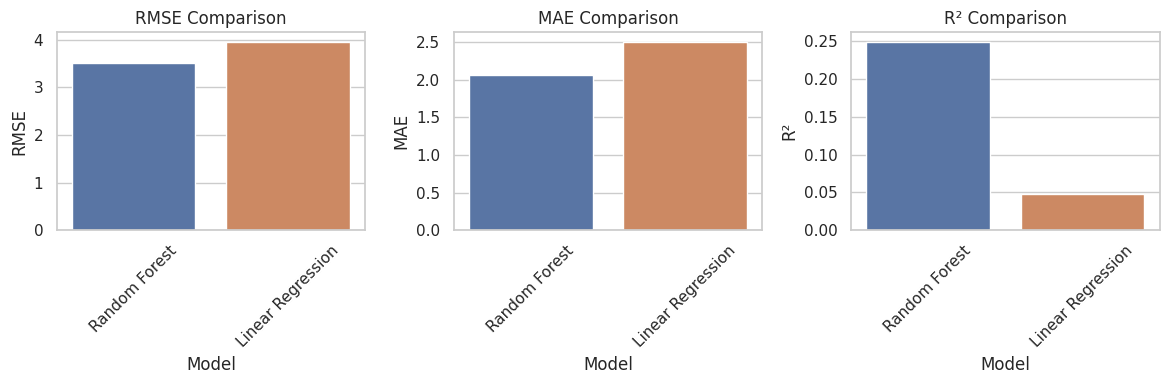


🏆 Champion Model: Random Forest
🎯 Best R²: 0.2496
⚡ Training completed successfully!


In [9]:
# Model Results Comparison and Champion Selection
if 'model_results_list' in locals() and len(model_results_list) > 0:
    print("📊 Comparing Model Performance...")
    
    # Create results dataframe
    model_results = pd.DataFrame(model_results_list)
    
    print(f"✅ Successfully trained {len(model_results)} models")
    print("\n📋 Results Summary:")
    display(model_results)
    
    # Visualization
    try:
        if task_type == 'regression':
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            metrics = ['RMSE', 'MAE', 'R²']
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            metrics = ['Accuracy', 'F1_Score']
        
        for i, metric in enumerate(metrics):
            if metric in model_results.columns:
                sns.barplot(data=model_results, x='Model', y=metric, ax=axes[i])
                axes[i].set_title(f'{metric} Comparison')
                axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization failed: {str(e)}")
    
    # Select champion model
    if task_type == 'regression':
        best_idx = model_results['R²'].idxmax()
        best_metric = 'R²'
        best_score = model_results.loc[best_idx, 'R²']
    else:
        best_idx = model_results['F1_Score'].idxmax()
        best_metric = 'F1_Score'
        best_score = model_results.loc[best_idx, 'F1_Score']
    
    champion_model_name = model_results.loc[best_idx, 'Model']
    champion_model = trained_models_dict[champion_model_name]
    
    print(f"\n🏆 Champion Model: {champion_model_name}")
    print(f"🎯 Best {best_metric}: {best_score:.4f}")
    print(f"⚡ Training completed successfully!")
    
    # Store for analysis
    trained_models = trained_models_dict
    
else:
    print("❌ No models were successfully trained.")
    print("💡 Please run the individual model training cells above.")

🔬 Starting detailed analysis of champion model...
🔬 CHAMPION MODEL ANALYSIS: Random Forest

🎯 FEATURE IMPORTANCE ANALYSIS:

📊 TOP 15 MOST IMPORTANT FEATURES:
   ride_distance_km          0.3284
   ride_duration             0.2885
   hour                      0.1179
   is_peak_hour              0.0913
   temperature_2m            0.0599
   is_weekend                0.0326
   weather_severity          0.0213
   traffic_max               0.0211
   traffic_mean              0.0147
   traffic_sum               0.0125
   precipitation             0.0044
   wind_speed_10m            0.0035
   has_precipitation         0.0021
   traffic_count             0.0011
   is_good_biking_weather    0.0004


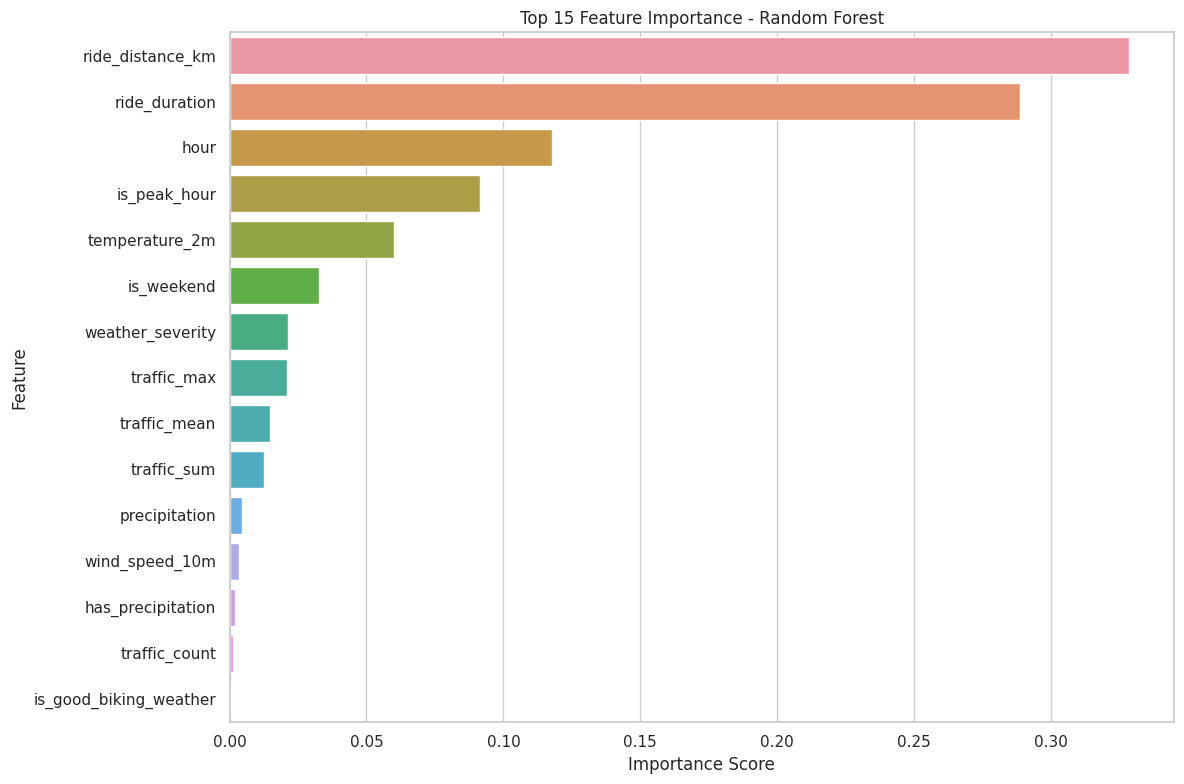


📈 FEATURE IMPORTANCE STATS:
   Total features: 17
   Features with >1% importance: 10
   Top 5 features contribute: 88.6%
   Top 10 features contribute: 98.8%

🎯 CROSS-VALIDATION PERFORMANCE:
   Mean CV RMSE: 3.510
   Std CV RMSE:  0.024
   CV Range:     3.469 - 3.543

📊 PREDICTION ANALYSIS:
   Mean Absolute Error: 2.072
   Mean Prediction: 3.440
   Mean Actual: 3.440
   Prediction Std: 1.960
   Actual Std: 4.059


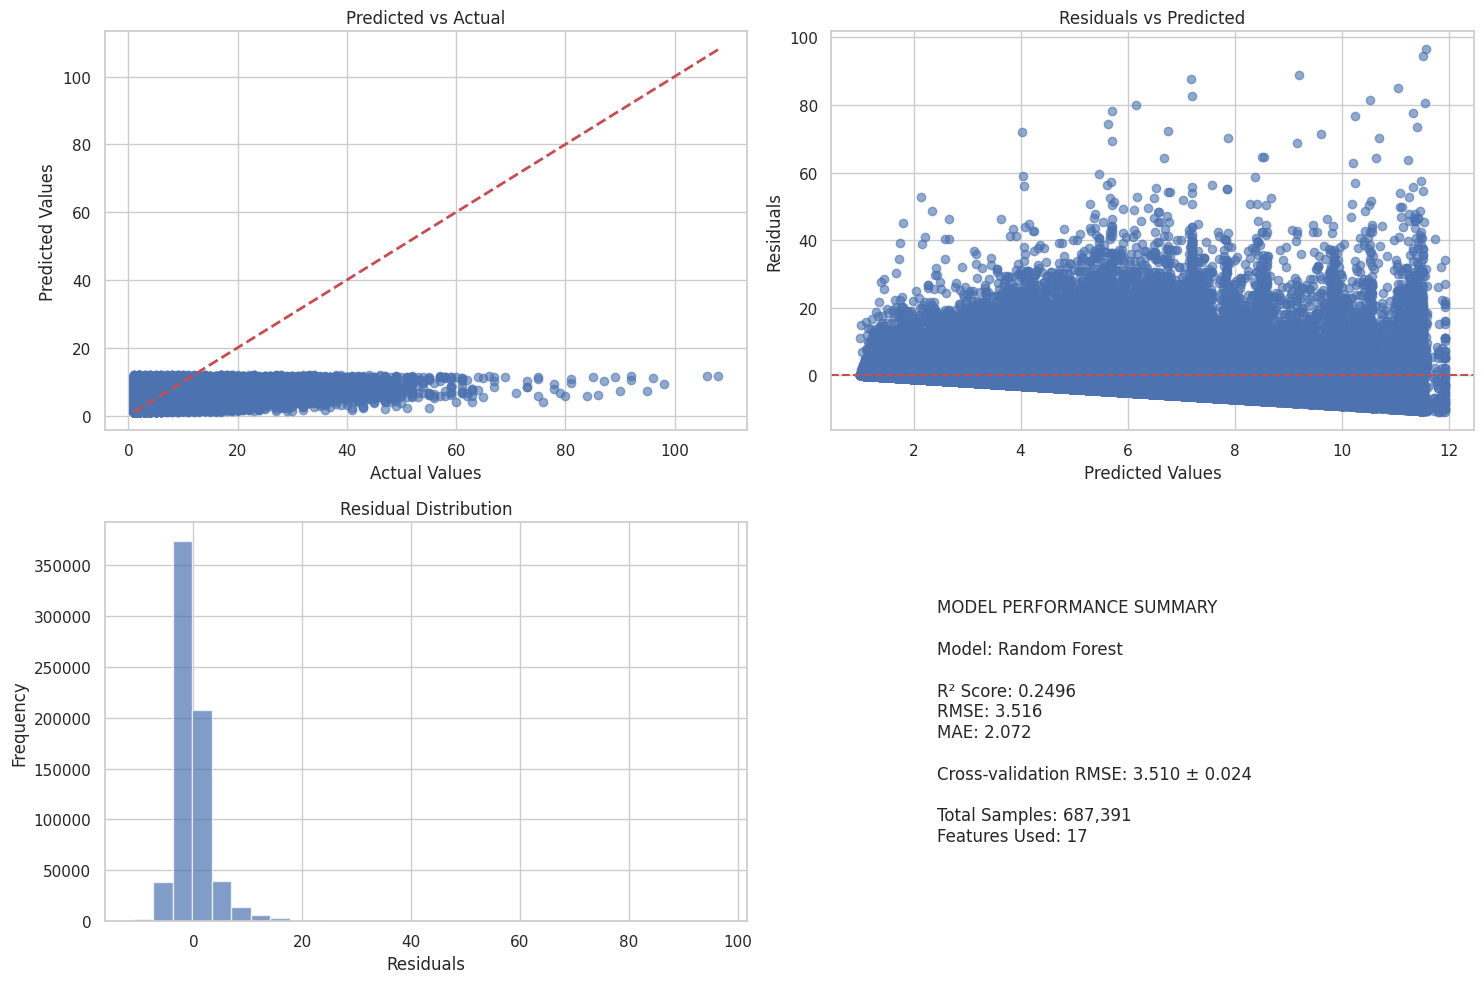


🎉 Champion model analysis completed!
🚀 Random Forest is ready for deployment


In [10]:
# ===============================
# Champion Model Analysis
# ===============================

def analyze_champion_model(model, X_test, y_test, feature_names, model_name):
    """Detailed analysis of the best performing model"""
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("="*70)
    print(f"🔬 CHAMPION MODEL ANALYSIS: {model_name}")
    print("="*70)
    
    # Ensure feature_names matches model input
    if len(feature_names) != X_test.shape[1]:
        print(f"⚠️ feature_names length ({len(feature_names)}) != X_test columns ({X_test.shape[1]}). Adjusting automatically.")
        feature_names = X_test.columns.tolist()
    
    # Feature Importance (tree-based models)
    if hasattr(model, 'feature_importances_'):
        print("\n🎯 FEATURE IMPORTANCE ANALYSIS:")
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Top 15 features
        top_features = feature_importance_df.head(15)
        print(f"\n📊 TOP 15 MOST IMPORTANT FEATURES:")
        for idx, row in top_features.iterrows():
            print(f"   {row['Feature']:<25} {row['Importance']:.4f}")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        sns.barplot(data=top_features, x='Importance', y='Feature')
        plt.title(f'Top 15 Feature Importance - {model_name}')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Feature importance statistics
        print(f"\n📈 FEATURE IMPORTANCE STATS:")
        print(f"   Total features: {len(feature_names)}")
        print(f"   Features with >1% importance: {sum(importances > 0.01)}")
        print(f"   Top 5 features contribute: {top_features.head(5)['Importance'].sum():.1%}")
        print(f"   Top 10 features contribute: {top_features.head(10)['Importance'].sum():.1%}")
        
        return feature_importance_df
    
    else:
        print("\n📊 Linear model - no feature importance available")
        return None


def analyze_model_performance(model, X_test, y_test, model_name, task_type):
    """Analyze model performance with plots"""
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    if task_type == 'regression':
        # Cross-validation performance
        print(f"\n🎯 CROSS-VALIDATION PERFORMANCE:")
        cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error')
        cv_scores = -cv_scores  # Convert to positive RMSE
        
        print(f"   Mean CV RMSE: {cv_scores.mean():.3f}")
        print(f"   Std CV RMSE:  {cv_scores.std():.3f}")
        print(f"   CV Range:     {cv_scores.min():.3f} - {cv_scores.max():.3f}")
        
        # Prediction analysis
        residuals = y_test - y_pred
        
        print(f"\n📊 PREDICTION ANALYSIS:")
        print(f"   Mean Absolute Error: {np.mean(np.abs(residuals)):.3f}")
        print(f"   Mean Prediction: {np.mean(y_pred):.3f}")
        print(f"   Mean Actual: {np.mean(y_test):.3f}")
        print(f"   Prediction Std: {np.std(y_pred):.3f}")
        print(f"   Actual Std: {np.std(y_test):.3f}")
        
        # Residual plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Predicted vs Actual
        axes[0,0].scatter(y_test, y_pred, alpha=0.6)
        axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual Values')
        axes[0,0].set_ylabel('Predicted Values')
        axes[0,0].set_title('Predicted vs Actual')
        
        # Residuals vs Predicted
        axes[0,1].scatter(y_pred, residuals, alpha=0.6)
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Predicted Values')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_title('Residuals vs Predicted')
        
        # Residual distribution
        axes[1,0].hist(residuals, bins=30, alpha=0.7)
        axes[1,0].set_xlabel('Residuals')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Residual Distribution')
        
        # Model performance summary
        axes[1,1].axis('off')
        performance_text = f"""
        MODEL PERFORMANCE SUMMARY
        
        Model: {model_name}
        
        R² Score: {r2_score(y_test, y_pred):.4f}
        RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}
        MAE: {mean_absolute_error(y_test, y_pred):.3f}
        
        Cross-validation RMSE: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}
        
        Total Samples: {len(y_test):,}
        Features Used: {X_test.shape[1]}
        """
        axes[1,1].text(0.1, 0.5, performance_text, fontsize=12, verticalalignment='center')
        
        plt.tight_layout()
        plt.show()
    
    else:  # Classification
        from sklearn.metrics import classification_report
        print(f"\n📊 CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred))


# ===============================
# Run Champion Model Analysis
# ===============================

if 'champion_model' in locals() and 'champion_model_name' in locals():
    print("🔬 Starting detailed analysis of champion model...")
    
    # Make sure feature names match the model input
    feature_names = X_train.columns.tolist()
    
    # Feature importance analysis
    feature_analysis = analyze_champion_model(
        champion_model, X_test, y_test, feature_names, champion_model_name
    )
    
    # Performance analysis
    analyze_model_performance(
        champion_model, X_test, y_test, champion_model_name, task_type
    )
    
    print(f"\n🎉 Champion model analysis completed!")
    print(f"🚀 {champion_model_name} is ready for deployment")
    
else:
    print("❌ No champion model available.")
    print("💡 Please run the model training and comparison cells first.")


In [11]:
# ===============================
# DEEP LEARNING FORECASTING MODULE
# ===============================

# Additional imports for deep learning forecasting
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prepare_time_series_data(df, target_col, sequence_length=24, forecast_horizon=1):
    """
    Prepare data for time series forecasting with deep learning models
    
    Args:
        df: DataFrame with time series data
        target_col: Column to predict
        sequence_length: Number of past time steps to use as input
        forecast_horizon: Number of future steps to predict
    """
    print(f"🔄 Preparing time series data for deep learning...")
    print(f"   📊 Sequence length: {sequence_length}")
    print(f"   🎯 Forecast horizon: {forecast_horizon}")
    
    # Sort by time if possible
    time_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['date', 'time', 'timestamp'])]
    if time_cols:
        print(f"   📅 Sorting by time column: {time_cols[0]}")
        df = df.sort_values(time_cols[0]).reset_index(drop=True)
    
    # Extract target values
    target_values = df[target_col].values
    
    # Create sequences
    X_sequences = []
    y_sequences = []
    
    for i in range(len(target_values) - sequence_length - forecast_horizon + 1):
        # Input sequence
        X_seq = target_values[i:(i + sequence_length)]
        # Target sequence (next values to predict)
        y_seq = target_values[(i + sequence_length):(i + sequence_length + forecast_horizon)]
        
        X_sequences.append(X_seq)
        y_sequences.append(y_seq)
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    # Reshape for LSTM/GRU (samples, timesteps, features)
    X_sequences = X_sequences.reshape(X_sequences.shape[0], X_sequences.shape[1], 1)
    
    # If forecasting single step, flatten y
    if forecast_horizon == 1:
        y_sequences = y_sequences.flatten()
    
    print(f"   ✅ Created {len(X_sequences)} sequences")
    print(f"   📐 Input shape: {X_sequences.shape}")
    print(f"   📐 Output shape: {y_sequences.shape}")
    
    return X_sequences, y_sequences

def create_lstm_model(sequence_length, forecast_horizon=1, units=50, layers=2, dropout=0.2):
    """
    Create LSTM model for time series forecasting
    """
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        
        # First LSTM layer
        model.add(LSTM(units, return_sequences=True if layers > 1 else False, 
                       input_shape=(sequence_length, 1)))
        model.add(Dropout(dropout))
        
        # Additional LSTM layers
        for i in range(1, layers):
            return_seq = i < layers - 1  # Return sequences for all but last layer
            model.add(LSTM(units, return_sequences=return_seq))
            model.add(Dropout(dropout))
        
        # Output layer
        model.add(Dense(forecast_horizon))
        
        # Compile model
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("❌ TensorFlow not available. Cannot create LSTM model.")
        return None

def create_gru_model(sequence_length, forecast_horizon=1, units=50, layers=2, dropout=0.2):
    """
    Create GRU model for time series forecasting
    """
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import GRU, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        
        # First GRU layer
        model.add(GRU(units, return_sequences=True if layers > 1 else False, 
                      input_shape=(sequence_length, 1)))
        model.add(Dropout(dropout))
        
        # Additional GRU layers
        for i in range(1, layers):
            return_seq = i < layers - 1
            model.add(GRU(units, return_sequences=return_seq))
            model.add(Dropout(dropout))
        
        # Output layer
        model.add(Dense(forecast_horizon))
        
        # Compile model
        model.compile(optimizer=Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mae'])
        
        return model
    except ImportError:
        print("❌ TensorFlow not available. Cannot create GRU model.")
        return None

def train_deep_learning_forecaster(X_train, y_train, X_val, y_val, model_type='lstm', 
                                 sequence_length=24, forecast_horizon=1, epochs=50):
    """
    Train deep learning model for forecasting
    """
    try:
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        
        print(f"🏋️ Training {model_type.upper()} forecasting model...")
        
        # Create model
        if model_type.lower() == 'lstm':
            model = create_lstm_model(sequence_length, forecast_horizon)
        elif model_type.lower() == 'gru':
            model = create_gru_model(sequence_length, forecast_horizon)
        else:
            raise ValueError("model_type must be 'lstm' or 'gru'")
        
        if model is None:
            return None, None
        
        print(f"   🏗️ Model architecture:")
        model.summary()
        
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        
        # Train model
        print(f"   🚀 Starting training for {epochs} epochs...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return model, history
    except ImportError:
        print("❌ TensorFlow not available. Cannot train deep learning model.")
        return None, None

def evaluate_forecasting_model(model, X_test, y_test, scaler=None, model_name="Deep Learning"):
    """
    Evaluate forecasting model performance
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    print(f"📊 Evaluating {model_name} forecasting model...")
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    
    # Handle scaling if provided
    if scaler is not None:
        # Inverse transform if scaled
        y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    else:
        y_test_orig = y_test
        y_pred_orig = y_pred.flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    
    # Calculate MAPE safely (avoid division by zero)
    y_test_nonzero = y_test_orig[y_test_orig != 0]
    y_pred_nonzero = y_pred_orig[y_test_orig != 0]
    
    if len(y_test_nonzero) > 0:
        mape = np.mean(np.abs((y_test_nonzero - y_pred_nonzero) / y_test_nonzero)) * 100
    else:
        mape = 0.0
    
    print(f"   📈 RMSE: {rmse:.3f}")
    print(f"   📈 MAE: {mae:.3f}")
    print(f"   📈 MAPE: {mape:.2f}%")
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'predictions': y_pred_orig,
        'actual': y_test_orig
    }

def plot_forecasting_results(results, title="Forecasting Results", n_samples=200):
    """
    Plot forecasting results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Time series comparison (last n_samples)
    actual = results['actual'][-n_samples:]
    predicted = results['predictions'][-n_samples:]
    
    axes[0,0].plot(actual, label='Actual', alpha=0.8)
    axes[0,0].plot(predicted, label='Predicted', alpha=0.8)
    axes[0,0].set_title(f'{title} - Time Series Comparison')
    axes[0,0].set_xlabel('Time Steps')
    axes[0,0].set_ylabel('Values')
    axes[0,0].legend()
    
    # Plot 2: Scatter plot
    axes[0,1].scatter(results['actual'], results['predictions'], alpha=0.6)
    min_val = min(results['actual'].min(), results['predictions'].min())
    max_val = max(results['actual'].max(), results['predictions'].max())
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual Values')
    axes[0,1].set_ylabel('Predicted Values')
    axes[0,1].set_title('Predicted vs Actual')
    
    # Plot 3: Residuals
    residuals = results['actual'] - results['predictions']
    axes[1,0].hist(residuals, bins=30, alpha=0.7)
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Residual Distribution')
    
    # Plot 4: Performance metrics
    axes[1,1].axis('off')
    metrics_text = f"""
    FORECASTING PERFORMANCE
    
    Model: {results['Model']}
    
    RMSE: {results['RMSE']:.3f}
    MAE: {results['MAE']:.3f}
    MAPE: {results['MAPE']:.2f}%
    
    Total Predictions: {len(results['actual']):,}
    """
    axes[1,1].text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

print("✅ Deep Learning Forecasting Module Loaded")
print("🚀 Ready for time series forecasting with LSTM and GRU models")

✅ Deep Learning Forecasting Module Loaded
🚀 Ready for time series forecasting with LSTM and GRU models


In [12]:
# ===============================
# DEEP LEARNING FORECASTING TRAINING
# ===============================

if 'df' in locals() and df is not None:
    print("🚀 Starting Deep Learning Forecasting Pipeline...")
    
    try:
        # Auto-detect target column for forecasting
        target_candidates = [col for col in df.columns if any(keyword in col.lower() 
                           for keyword in ['demand', 'count', 'target', 'y', 'rides', 'trips'])]
        
        if target_candidates:
            forecast_target = target_candidates[0]
            print(f"🎯 Using target column for forecasting: {forecast_target}")
        else:
            print("❌ No suitable target column found for forecasting")
            print(f"Available columns: {list(df.columns)}")
            forecast_target = None
        
        if forecast_target is not None:
            # Parameters for forecasting
            SEQUENCE_LENGTH = 24  # Use 24 time steps to predict next value
            FORECAST_HORIZON = 1  # Predict 1 step ahead
            
            print(f"\n📊 Preparing time series data...")
            print(f"   🔢 Target column: {forecast_target}")
            print(f"   📈 Target stats: {df[forecast_target].describe()}")
            
            # For large datasets, sample a subset for faster training
            if len(df) > 500000:
                print(f"   ⚡ Large dataset detected ({len(df):,} rows). Sampling 500k for speed...")
                df_sample = df.sample(n=500000, random_state=42).reset_index(drop=True)
                # Sort by date to maintain time order
                time_cols = [col for col in df_sample.columns if any(keyword in col.lower() for keyword in ['date', 'time', 'timestamp'])]
                if time_cols:
                    df_sample = df_sample.sort_values(time_cols[0]).reset_index(drop=True)
            else:
                df_sample = df.copy()
            
            # Prepare sequences for deep learning
            X_sequences, y_sequences = prepare_time_series_data(
                df_sample, forecast_target, SEQUENCE_LENGTH, FORECAST_HORIZON
            )
            
            if len(X_sequences) > 100:  # Need sufficient data for deep learning
                # Scale the data for better training
                scaler = MinMaxScaler()
                
                # Fit scaler on the target column
                target_values = df_sample[forecast_target].values.reshape(-1, 1)
                scaler.fit(target_values)
                
                # Scale sequences
                X_scaled = X_sequences.copy()
                for i in range(len(X_scaled)):
                    X_scaled[i] = scaler.transform(X_scaled[i])
                
                y_scaled = scaler.transform(y_sequences.reshape(-1, 1)).flatten()
                
                # Train/validation/test split for time series
                train_size = int(0.7 * len(X_scaled))
                val_size = int(0.15 * len(X_scaled))
                
                X_train_dl = X_scaled[:train_size]
                y_train_dl = y_scaled[:train_size]
                
                X_val_dl = X_scaled[train_size:train_size + val_size]
                y_val_dl = y_scaled[train_size:train_size + val_size]
                
                X_test_dl = X_scaled[train_size + val_size:]
                y_test_dl = y_scaled[train_size + val_size:]
                
                print(f"\n📊 Deep Learning Data Split:")
                print(f"   🏋️ Training: {len(X_train_dl)} sequences")
                print(f"   🧪 Validation: {len(X_val_dl)} sequences")
                print(f"   📊 Test: {len(X_test_dl)} sequences")
                
                # Store for model training
                dl_data_ready = True
                forecasting_scaler = scaler
                
            else:
                print(f"❌ Insufficient data for deep learning: {len(X_sequences)} sequences")
                print("💡 Need at least 100 sequences for training")
                dl_data_ready = False
        
    except Exception as e:
        print(f"❌ Error preparing deep learning data: {str(e)}")
        dl_data_ready = False

else:
    print("❌ No dataset loaded for deep learning forecasting")
    dl_data_ready = False

🚀 Starting Deep Learning Forecasting Pipeline...
🎯 Using target column for forecasting: demand_count

📊 Preparing time series data...
   🔢 Target column: demand_count
   📈 Target stats: count    6.298240e+06
mean     3.403433e+00
std      4.046097e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.460000e+02
Name: demand_count, dtype: float64
   ⚡ Large dataset detected (6,298,240 rows). Sampling 500k for speed...
🔄 Preparing time series data for deep learning...
   📊 Sequence length: 24
   🎯 Forecast horizon: 1
   📅 Sorting by time column: date
   ✅ Created 499976 sequences
   📐 Input shape: (499976, 24, 1)
   📐 Output shape: (499976,)

📊 Deep Learning Data Split:
   🏋️ Training: 349983 sequences
   🧪 Validation: 74996 sequences
   📊 Test: 74997 sequences


In [ ]:
# Train LSTM Forecasting Model
if 'dl_data_ready' in locals() and dl_data_ready:
    print("🏋️ Training LSTM Forecasting Model...")
    
    try:
        # Train LSTM model
        lstm_model, lstm_history = train_deep_learning_forecaster(
            X_train_dl, y_train_dl, X_val_dl, y_val_dl,
            model_type='lstm', 
            sequence_length=SEQUENCE_LENGTH,
            forecast_horizon=FORECAST_HORIZON,
            epochs=50
        )
        
        # Evaluate LSTM
        lstm_results = evaluate_forecasting_model(
            lstm_model, X_test_dl, y_test_dl, 
            scaler=forecasting_scaler, 
            model_name="LSTM Forecasting"
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(lstm_history.history['loss'], label='Training Loss')
        plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
        plt.title('LSTM Training History - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(lstm_history.history['mae'], label='Training MAE')
        plt.plot(lstm_history.history['val_mae'], label='Validation MAE')
        plt.title('LSTM Training History - MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Plot forecasting results
        plot_forecasting_results(lstm_results, "LSTM Forecasting Results")
        
        print("✅ LSTM model training completed!")
        
    except Exception as e:
        print(f"❌ LSTM training failed: {str(e)}")
        lstm_results = None

else:
    print("❌ Deep learning data not ready. Cannot train LSTM.")

🏋️ Training LSTM Forecasting Model...


2025-09-14 22:29:17.637476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757888957.794162      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757888957.844990      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🏋️ Training LSTM forecasting model...


I0000 00:00:1757888968.782593      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


   🏗️ Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

   🚀 Starting training for 50 epochs...
Epoch 1/50


I0000 00:00:1757888973.471373     438 cuda_dnn.cc:529] Loaded cuDNN version 90300


10937/10937 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 0.0014 - mae: 0.0243 - val_loss: 0.0013 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 2/50
 1063/10937 ━━━━━━━━━━━━━━━━━━━━ 1:00 6ms/step - loss: 0.0013 - mae: 0.0238

In [ ]:
# Train GRU Forecasting Model
if 'dl_data_ready' in locals() and dl_data_ready:
    print("🏋️ Training GRU Forecasting Model...")
    
    try:
        # Train GRU model
        gru_model, gru_history = train_deep_learning_forecaster(
            X_train_dl, y_train_dl, X_val_dl, y_val_dl,
            model_type='gru', 
            sequence_length=SEQUENCE_LENGTH,
            forecast_horizon=FORECAST_HORIZON,
            epochs=50
        )
        
        # Evaluate GRU
        gru_results = evaluate_forecasting_model(
            gru_model, X_test_dl, y_test_dl, 
            scaler=forecasting_scaler, 
            model_name="GRU Forecasting"
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(gru_history.history['loss'], label='Training Loss')
        plt.plot(gru_history.history['val_loss'], label='Validation Loss')
        plt.title('GRU Training History - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(gru_history.history['mae'], label='Training MAE')
        plt.plot(gru_history.history['val_mae'], label='Validation MAE')
        plt.title('GRU Training History - MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Plot forecasting results
        plot_forecasting_results(gru_results, "GRU Forecasting Results")
        
        print("✅ GRU model training completed!")
        
    except Exception as e:
        print(f"❌ GRU training failed: {str(e)}")
        gru_results = None

else:
    print("❌ Deep learning data not ready. Cannot train GRU.")

In [ ]:
# Compare All Models (Traditional ML + Deep Learning)
if 'model_results_list' in locals() and len(model_results_list) > 0:
    print("📊 COMPREHENSIVE MODEL COMPARISON")
    print("="*60)
    
    # Combine traditional ML and deep learning results
    all_results = model_results_list.copy()
    
    # Add deep learning results if available
    if 'lstm_results' in locals() and lstm_results is not None:
        lstm_summary = {
            'Model': 'LSTM Forecasting',
            'RMSE': lstm_results['RMSE'],
            'MAE': lstm_results['MAE'],
            'MAPE': lstm_results['MAPE']
        }
        all_results.append(lstm_summary)
    
    if 'gru_results' in locals() and gru_results is not None:
        gru_summary = {
            'Model': 'GRU Forecasting',
            'RMSE': gru_results['RMSE'],
            'MAE': gru_results['MAE'],
            'MAPE': gru_results['MAPE']
        }
        all_results.append(gru_summary)
    
    # Create comprehensive results dataframe
    comprehensive_results = pd.DataFrame(all_results)
    
    print(f"✅ Total models trained: {len(comprehensive_results)}")
    print("\n📋 COMPREHENSIVE RESULTS:")
    display(comprehensive_results)
    
    # Visualization comparing all models
    if len(comprehensive_results) > 1:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # RMSE comparison
        if 'RMSE' in comprehensive_results.columns:
            sns.barplot(data=comprehensive_results, x='Model', y='RMSE', ax=axes[0])
            axes[0].set_title('RMSE Comparison (Lower is Better)')
            axes[0].tick_params(axis='x', rotation=45)
        
        # MAE comparison
        if 'MAE' in comprehensive_results.columns:
            sns.barplot(data=comprehensive_results, x='Model', y='MAE', ax=axes[1])
            axes[1].set_title('MAE Comparison (Lower is Better)')
            axes[1].tick_params(axis='x', rotation=45)
        
        # MAPE comparison (for forecasting models)
        mape_data = comprehensive_results[comprehensive_results['MAPE'].notna()] if 'MAPE' in comprehensive_results.columns else None
        if mape_data is not None and len(mape_data) > 0:
            sns.barplot(data=mape_data, x='Model', y='MAPE', ax=axes[2])
            axes[2].set_title('MAPE Comparison (Lower is Better)')
            axes[2].tick_params(axis='x', rotation=45)
        else:
            axes[2].axis('off')
            axes[2].text(0.5, 0.5, 'MAPE only available\nfor forecasting models', 
                        ha='center', va='center', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
    # Select overall champion
    if 'RMSE' in comprehensive_results.columns:
        best_model_idx = comprehensive_results['RMSE'].idxmin()
        overall_champion = comprehensive_results.loc[best_model_idx, 'Model']
        best_rmse = comprehensive_results.loc[best_model_idx, 'RMSE']
        
        print(f"\n🏆 OVERALL CHAMPION MODEL: {overall_champion}")
        print(f"🎯 Best RMSE: {best_rmse:.4f}")
        
        # Determine model type
        if 'forecasting' in overall_champion.lower():
            print("🔮 Champion is a deep learning forecasting model!")
            print("⚡ Excellent for time series prediction tasks")
        else:
            print("📊 Champion is a traditional ML model!")
            print("⚡ Excellent for general prediction tasks")
    
    print(f"\n🚀 Model comparison completed!")
    print(f"📈 You now have {len(comprehensive_results)} trained models ready for deployment")

else:
    print("❌ No model results available for comparison")